<a href="https://colab.research.google.com/github/Freesoul-tech/Louis-Mahobe/blob/main/Hard33.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[..., tf.newaxis] / 255.0
x_test = x_test[..., tf.newaxis] / 255.0

# Build model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

# Compile and train
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, validation_split=0.1)
model.evaluate(x_test, y_test)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.8880 - loss: 0.3594 - val_accuracy: 0.9790 - val_loss: 0.0636
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - accuracy: 0.9838 - loss: 0.0533 - val_accuracy: 0.9833 - val_loss: 0.0531
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.9892 - loss: 0.0360 - val_accuracy: 0.9870 - val_loss: 0.0450
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 83s 29ms/step - accuracy: 0.9921 - loss: 0.0255 - val_accuracy: 0.9897 - val_loss: 0.0417
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 80s 28ms/step - accuracy: 0.9936 - loss: 0.0204 - val_accuracy: 0.9898 - val_loss: 0.0376
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9867 - loss: 0.0407


[0.03358864784240723, 0.9894000291824341]

In [3]:
from torchvision import transforms

simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])


In [4]:
import torch.nn as nn
import torchvision.models as models

class SimCLRModel(nn.Module):
    def __init__(self, base_model='resnet18', out_dim=128):
        super().__init__()
        self.encoder = models.__dict__[base_model](pretrained=False)
        self.encoder.fc = nn.Identity()  # Remove final classification layer
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return z


In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Load dataset (e.g., CIFAR-10)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32)
])
dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=False)

# Extract features
all_features = []
all_labels = []


simclr_model_instance = SimCLRModel(base_model='resnet18', out_dim=128).to(device)

simclr_model_instance.eval() # Use the PyTorch model instance
with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        features = simclr_model_instance.encoder(images)  # Use the PyTorch model instance's encoder
        all_features.append(features.cpu())
        all_labels.append(labels)

features = torch.cat(all_features).numpy()
labels = torch.cat(all_labels).numpy()

print("Feature extraction complete.")
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

Using device: cpu


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Feature extraction complete.
Features shape: (10000, 512)
Labels shape: (10000,)


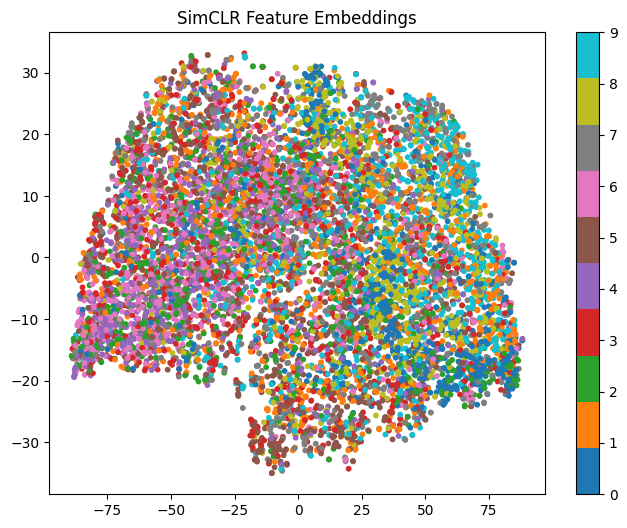

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', s=10)
plt.title("SimCLR Feature Embeddings")
plt.colorbar()
plt.show()


In [9]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load and preprocess
iris = load_iris()
X = iris.data[iris.target != 0]
y = iris.target[iris.target != 0] - 1  # Binary: versicolor vs virginica

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.1953 - loss: 0.8768
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2352 - loss: 0.8641
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2391 - loss: 0.8526
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2273 - loss: 0.8350
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2453 - loss: 0.8356
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2320 - loss: 0.8206
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2789 - loss: 0.8067
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2062 - loss: 0.8074
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2453 - loss: 0.7900
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2664 - loss: 0.7828
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3141 - loss: 0.7741
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3148 - loss: 0.7660
Epoch 13/50


In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load and split
housing = fetch_california_housing()
X, y = housing.data, housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build Keras model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8320
Epoch 2/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4725
Epoch 3/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4123
Epoch 4/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4120
Epoch 5/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3695
Epoch 6/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3825
Epoch 7/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3722
Epoch 8/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3785
Epoch 9/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3491
Epoch 10/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3445
Epoch 11/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3313
Epoch 12/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3304
Epoch 13/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3508
Epoch 14/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3369
Epoch 15/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

In [14]:
X = iris.data
y = iris.target  # 0, 1, 2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3292 - loss: 1.1107
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3208 - loss: 1.0834
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2740 - loss: 1.1008
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3719 - loss: 1.0076
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2823 - loss: 1.0455
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3208 - loss: 0.9965
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3348 - loss: 0.9592
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3487 - loss: 0.9423
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4079 - loss: 0.9207
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4733 - loss: 0.8782
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4635 - loss: 0.8666
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5600 - loss: 0.8526
E

In [15]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100)


Epoch 1/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.8637
Epoch 2/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4821
Epoch 3/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4260
Epoch 4/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3886
Epoch 5/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3969
Epoch 6/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3771
Epoch 7/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3679
Epoch 8/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3637
Epoch 9/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3491
Epoch 10/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3435
Epoch 11/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3542
Epoch 12/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3276
Epoch 13/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3658
Epoch 14/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3411
Epoch 15/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1

In [16]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[..., tf.newaxis] / 255.0
x_test = x_test[..., tf.newaxis] / 255.0

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, validation_split=0.1)
model.evaluate(x_test, y_test)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 53s 30ms/step - accuracy: 0.8948 - loss: 0.3420 - val_accuracy: 0.9850 - val_loss: 0.0564
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 49s 29ms/step - accuracy: 0.9828 - loss: 0.0567 - val_accuracy: 0.9882 - val_loss: 0.0449
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - accuracy: 0.9894 - loss: 0.0345 - val_accuracy: 0.9815 - val_loss: 0.0638
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 50s 29ms/step - accuracy: 0.9924 - loss: 0.0260 - val_accuracy: 0.9878 - val_loss: 0.0404
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.9932 - loss: 0.0201 - val_accuracy: 0.9878 - val_loss: 0.0400
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9836 - loss: 0.0506


[0.040457725524902344, 0.9876999855041504]

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data prep
iris = load_iris()
X = iris.data[iris.target != 0]
y = iris.target[iris.target != 0] - 1  # Binary: 0 or 1

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Model
class BinaryIrisModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = BinaryIrisModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training
for epoch in range(50):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            acc = ((model(X_test) > 0.5) == y_test).float().mean()
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, Accuracy={acc:.4f}")


Epoch 0: Loss=0.6686, Accuracy=0.5500
Epoch 10: Loss=0.4904, Accuracy=1.0000
Epoch 20: Loss=0.3610, Accuracy=1.0000
Epoch 30: Loss=0.2695, Accuracy=1.0000
Epoch 40: Loss=0.2000, Accuracy=1.0000


In [20]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

# Data prep
iris = load_iris()
X = iris.data
y = iris.target  # 0, 1, 2

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


class MultiIrisModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.net(x)

model = MultiIrisModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(50):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            preds = torch.argmax(model(X_test), dim=1)
            acc = (preds == y_test).float().mean()
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, Accuracy={acc:.4f}")

Epoch 0: Loss=1.0421, Accuracy=0.4333
Epoch 10: Loss=0.7136, Accuracy=0.8000
Epoch 20: Loss=0.4760, Accuracy=0.8000
Epoch 30: Loss=0.3359, Accuracy=0.8333
Epoch 40: Loss=0.2554, Accuracy=0.8333


In [21]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X, y = housing.data, housing.target

X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

class HousePriceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = HousePriceModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            test_loss = criterion(model(X_test), y_test)
            print(f"Epoch {epoch}: Train Loss={loss.item():.4f}, Test Loss={test_loss.item():.4f}")


Epoch 0: Train Loss=5.0213, Test Loss=4.2117
Epoch 10: Train Loss=1.0919, Test Loss=0.9870
Epoch 20: Train Loss=0.8866, Test Loss=0.8552
Epoch 30: Train Loss=0.7134, Test Loss=0.7098
Epoch 40: Train Loss=0.6058, Test Loss=0.6173
Epoch 50: Train Loss=0.5328, Test Loss=0.5478
Epoch 60: Train Loss=0.4826, Test Loss=0.4978
Epoch 70: Train Loss=0.4477, Test Loss=0.4632
Epoch 80: Train Loss=0.4250, Test Loss=0.4403
Epoch 90: Train Loss=0.4106, Test Loss=0.4242


In [26]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.net(x)

model = MNISTModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Collect loss values during training
train_losses = []

for epoch in range(5):
    epoch_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * images.size(0) # Accumulate loss for the epoch

    epoch_loss /= len(train_loader.dataset) # Average loss over the epoch
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1} complete, Loss: {epoch_loss:.4f}")


# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)
        preds = torch.argmax(output, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")

Epoch 1 complete, Loss: 0.2025
Epoch 2 complete, Loss: 0.0566
Epoch 3 complete, Loss: 0.0397
Epoch 4 complete, Loss: 0.0306
Epoch 5 complete, Loss: 0.0244
Test Accuracy: 0.9905


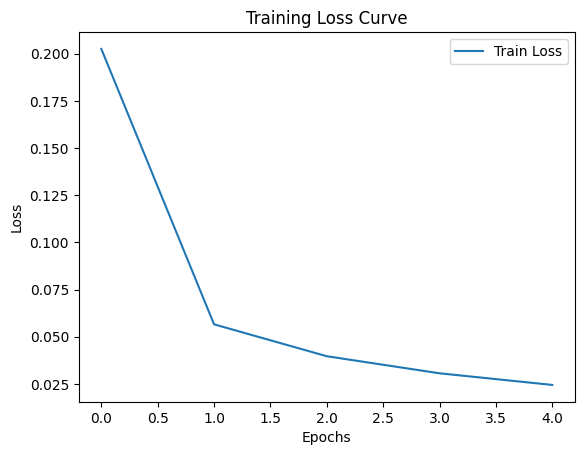

In [27]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(train_losses, label='Train Loss')
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()